In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
!pip install xgboost
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1
import warnings
warnings.simplefilter('ignore', FutureWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.patches as patches
from sklearn.metrics import jaccard_score

In [30]:
from imblearn.combine import SMOTEENN

In [25]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/04/train_april.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/04/test_april.csv')

In [26]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row', 'col'])
y_train = (train_df['AWS'] > 0).astype(int)

X_test = test_df.drop(columns=['AWS', 'datetime', 'row', 'col'])
y_test = (test_df['AWS'] > 0).astype(int)

# Chuẩn hóa dữ liệu

In [27]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Chọn đặc trưng

In [28]:
top_features =  ['CAPE', 'KX', 'R500', 'R850', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B10B', 'B11B', 'B14B', 'I2B', 'I4B', 'IRB', 'WVB']

# Cân bằng dữ liệu

## SMOTE

In [ ]:
# sm = SMOTE(random_state=42)
# X_sm, y_sm = sm.fit_resample(X_train, y_train)

# scaler = MinMaxScaler()
# X_train_scaled_sm = scaler.fit_transform(X_sm)
# X_test_scaled_sm = scaler.transform(X_test) 

# X_train_scaled_sm = pd.DataFrame(X_train_scaled_sm, columns=X_train.columns)
# X_test_scaled_sm = pd.DataFrame(X_test_scaled_sm, columns=X_test.columns)

## SMOTE ENN

In [31]:
smenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smenn.fit_resample(X_train, y_train)

scaler = MinMaxScaler()
X_train_scaled_smenn = scaler.fit_transform(X_resampled)
X_test_scaled_smenn = scaler.transform(X_test) 

X_train_scaled_smenn = pd.DataFrame(X_train_scaled_smenn, columns=X_train.columns)
X_test_scaled_smenn = pd.DataFrame(X_test_scaled_smenn, columns=X_test.columns)


# Mô hình tốt nhất

# CatBoost

Accuracy : 0.8714298488777609
Precision: 0.3948412698412698
Recall   : 0.5331309162350419
F1 Score : 0.4536818907211794

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93     50316
           1       0.39      0.53      0.45      5599

    accuracy                           0.87     55915
   macro avg       0.67      0.72      0.69     55915
weighted avg       0.89      0.87      0.88     55915



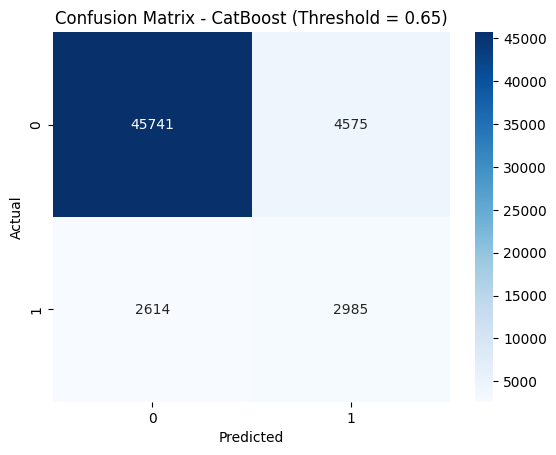

In [32]:
catboost_model = CatBoostClassifier(
    iterations=424,
    learning_rate=0.23472900662307233,
    depth=3,
    l2_leaf_reg=6.300285930745067,
    random_strength=0.8863504360315755,
    bagging_temperature=0.07251995420518192,
    random_seed=42,
    verbose=0
)

catboost_model.fit(X_train_scaled_smenn, y_resampled)

y_probs = catboost_model.predict_proba(X_test_scaled_smenn)[:, 1]
THRESHOLD = 0.65
y_pred_cat = (y_probs >= THRESHOLD).astype(int)

acc = accuracy_score(y_test, y_pred_cat)
prec = precision_score(y_test, y_pred_cat)
rec = recall_score(y_test, y_pred_cat)
f1 = f1_score(y_test, y_pred_cat)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat))

cm = confusion_matrix(y_test, y_pred_cat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - CatBoost (Threshold = {THRESHOLD})')
plt.show()


# Vẽ bản đồ mưa

In [39]:
df_map = test_df[['datetime', 'row', 'col']].copy()
df_map['y_true'] = y_test.values
df_map['y_pred_cat'] = y_pred_cat
df_map

,datetime,row,col,y_true,y_pred_cat
0,2020-04-19 00:00:00,0,114,0,0
1,2020-04-19 01:00:00,0,114,0,0
2,2020-04-19 02:00:00,0,114,0,0
3,2020-04-19 03:00:00,0,114,0,0
4,2020-04-19 04:00:00,0,114,0,0
...,...,...,...,...,...
55910,2020-04-30 15:00:00,87,136,0,0
55911,2020-04-30 16:00:00,87,136,0,0
55912,2020-04-30 17:00:00,87,136,0,0
55913,2020-04-30 18:00:00,87,136,0,0


In [40]:
def evaluate(y_true, y_pred, model_name, timestamp):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    iou = jaccard_score(y_true, y_pred, zero_division=0)
    
    return {
        'Datetime': timestamp,  
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'IoU': iou
    }

In [41]:
def plot_true_vs_cat(df_plot):
    datasets = [
        ('y_true', 'Thực tế'),
        ('y_pred_cat', 'Dự đoán Catboost khi huấn luyện trên tháng 4')
    ]

    # Tránh SettingWithCopyWarning bằng cách tạo bản sao rõ ràng
    df_plot = df_plot.copy()

    # Chuyển datetime nếu chưa đúng kiểu
    if not df_plot.empty and not pd.api.types.is_datetime64_any_dtype(df_plot['datetime']):
        df_plot['datetime'] = pd.to_datetime(df_plot['datetime'])

    timestamp = df_plot['datetime'].iloc[0].strftime('%Y-%m-%d %H:%M:%S') if not df_plot.empty else "Không có dữ liệu"

    vmax_values = []
    images = []

    for col, _ in datasets:
        image = np.zeros((90, 250))
        for _, row in df_plot.iterrows():
            r = row['row']
            c = row['col']
            value = row[col]
            image[r, c] = value
        cropped = image[:, 50:201]
        images.append(cropped)
        vmax_values.append(np.max(cropped))
    
    max_vmax = max(vmax_values)

    fig, axs = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)
    titles = [title for _, title in datasets]

    for i, ax in enumerate(axs):
        cropped_image = images[i]
        cmap = 'Blues'
        im = ax.imshow(cropped_image, cmap=cmap, aspect='auto', vmin=0.01, vmax=max_vmax)
        ax.set_title(titles[i], fontsize=12)
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        ax.set_xticks(ticks=np.arange(0, cropped_image.shape[1], 10))
        ax.set_xticklabels(np.arange(50, 201, 10))

        boxes = [
            {"xy": (95 - 50, 0), "width": 21, "height": 19, "edgecolor": 'r', "label": 'Hoà Bình'},
            {"xy": (84 - 50, 10), "width": 43, "height": 35, "edgecolor": 'g', "label": 'Thanh Hoá'},
            {"xy": (71 - 50, 27), "width": 49, "height": 36, "edgecolor": 'b', "label": 'Nghệ An'},
            {"xy": (102 - 50, 62), "width": 35, "height": 18, "edgecolor": 'y', "label": 'Hà Tĩnh'}
        ]
        for box in boxes:
            rect = patches.Rectangle(**box, linewidth=2, facecolor='none')
            ax.add_patch(rect)
        
        if i == 0:
            handles = [patches.Patch(color=box["edgecolor"], label=box["label"]) for box in boxes]
            ax.legend(handles=handles, loc='upper right')

    fig.suptitle(f'Bản đồ mưa tại {timestamp}', fontsize=16, fontname='DejaVu Sans')
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, label='Rain (1) / No rain (0)')

    output_filename = f"rain_map_{df_plot['datetime'].iloc[0].strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(output_filename, dpi=300)
    print(f"✅ Đã lưu ảnh: {output_filename}")
    plt.show()


In [45]:
timestamp1 = '2020-04-22 20:00:00'
timestamp2 = '2020-04-23 01:00:00'
timestamp3 = '2020-04-24 08:00:00'
timestamp4 = '2020-04-25 19:00:00'

df_plot1 = df_map[df_map['datetime'] == timestamp1]
df_plot2 = df_map[df_map['datetime'] == timestamp2]
df_plot3 = df_map[df_map['datetime'] == timestamp3]
df_plot4 = df_map[df_map['datetime'] == timestamp4]

✅ Đã lưu ảnh: rain_map_20200422_200000.png


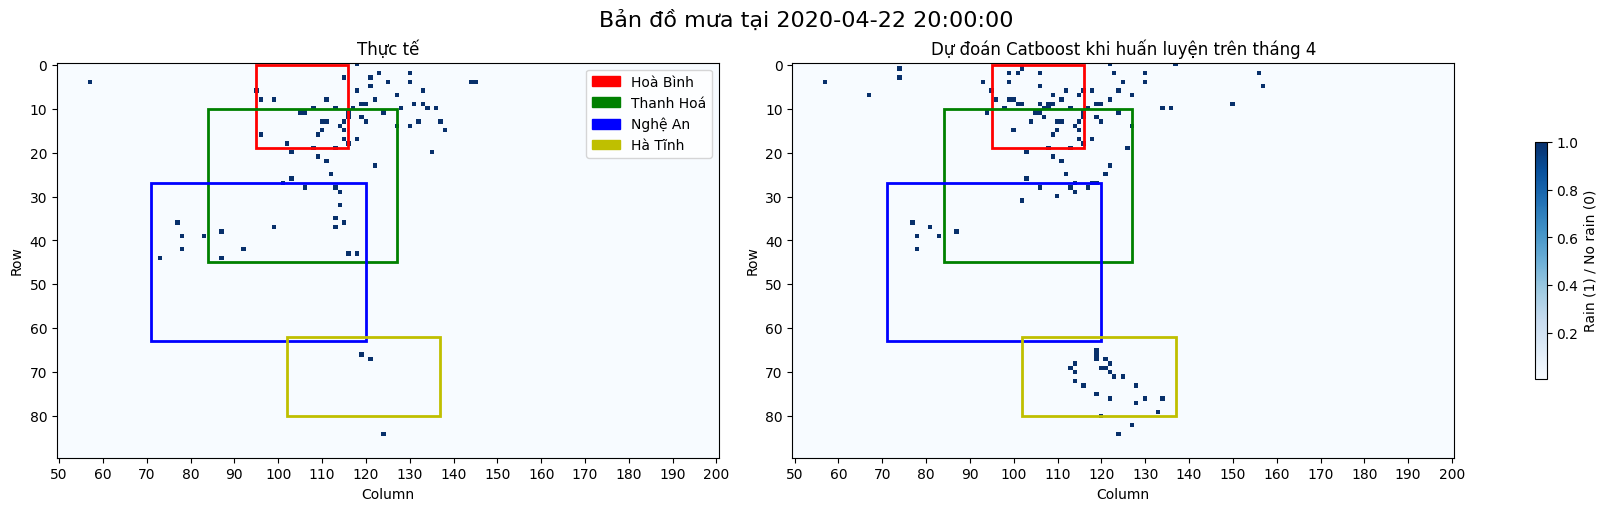

In [46]:
plot_true_vs_cat(df_plot1)

✅ Đã lưu ảnh: rain_map_20200423_010000.png


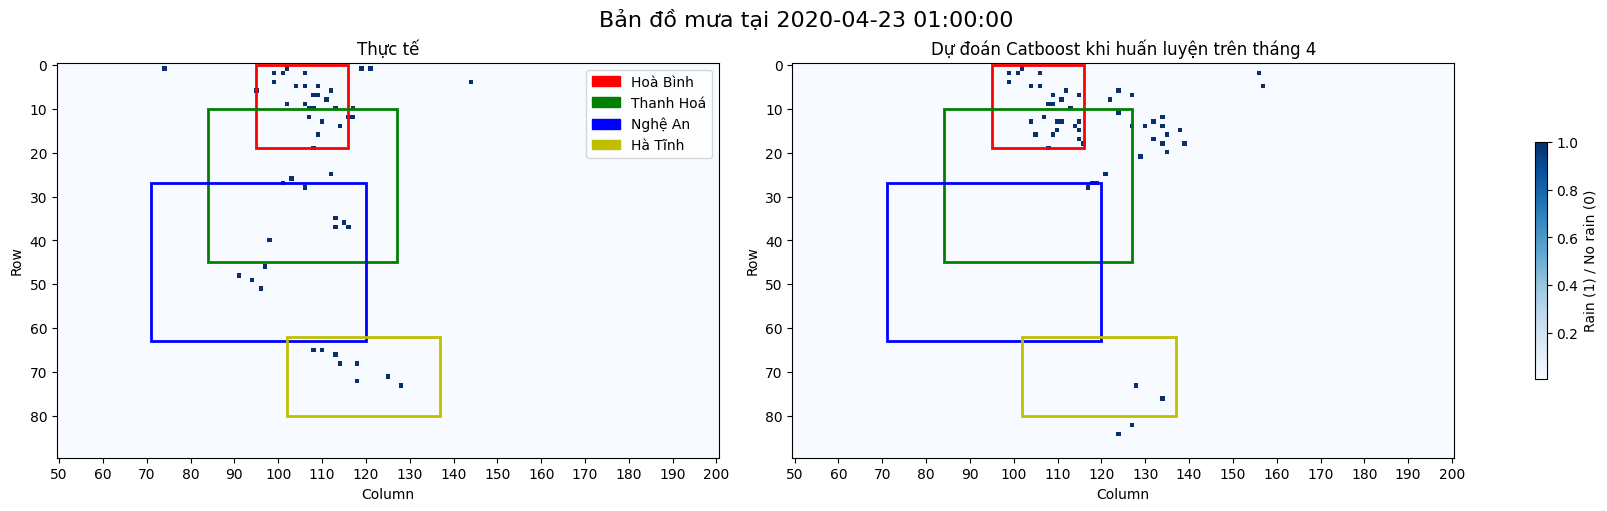

In [47]:
plot_true_vs_cat(df_plot2)

✅ Đã lưu ảnh: rain_map_20200424_080000.png


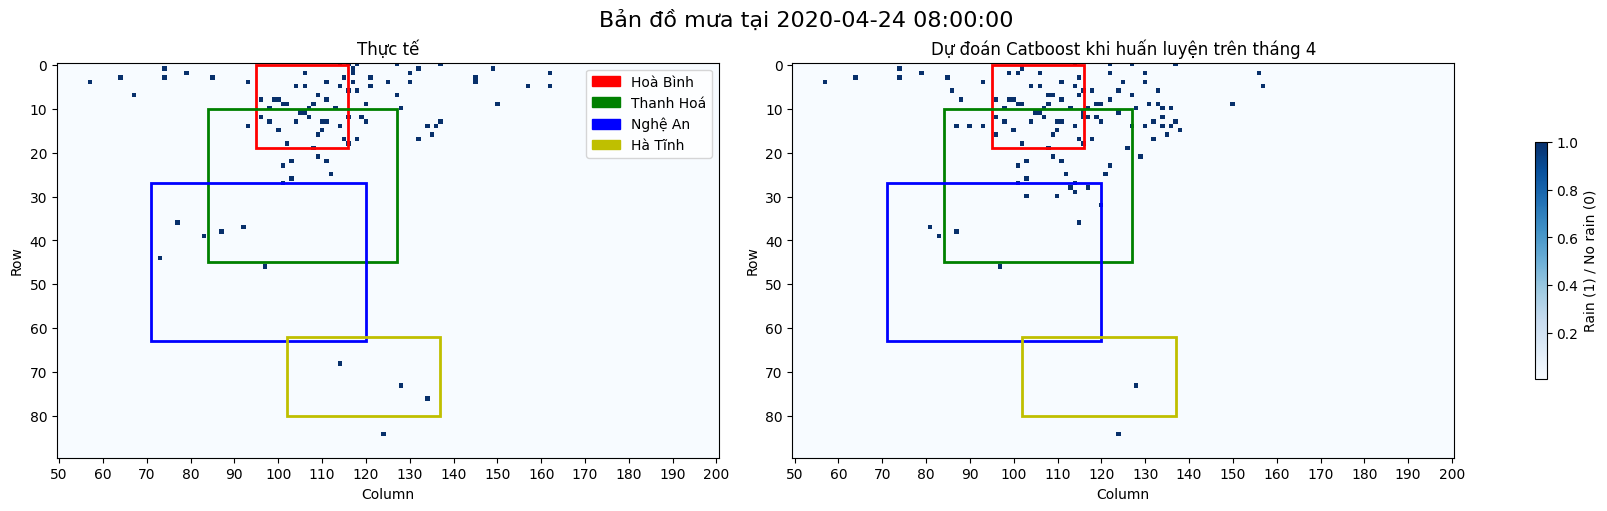

In [48]:
plot_true_vs_cat(df_plot3)

✅ Đã lưu ảnh: rain_map_20200425_190000.png


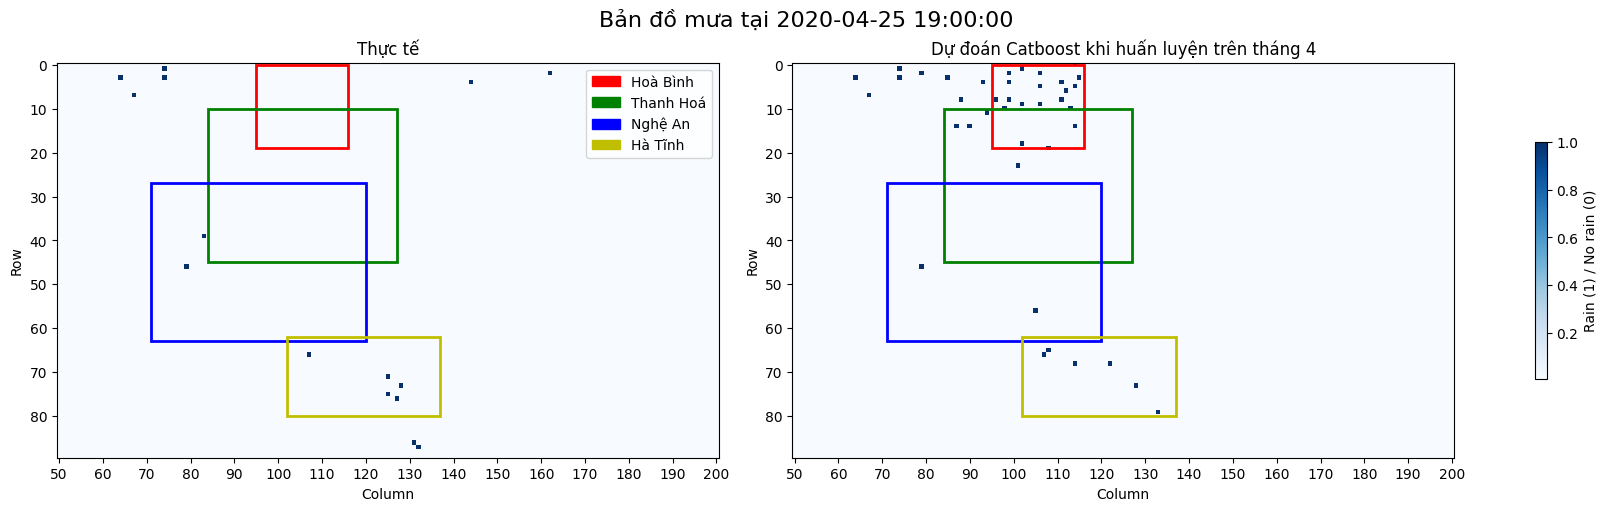

In [49]:
plot_true_vs_cat(df_plot4)

In [50]:
results = []

results.append(evaluate(df_plot1['y_true'], df_plot1['y_pred_cat'], 'CatBoost', timestamp1))
results.append(evaluate(df_plot2['y_true'], df_plot2['y_pred_cat'], 'CatBoost', timestamp2))
results.append(evaluate(df_plot3['y_true'], df_plot3['y_pred_cat'], 'CatBoost', timestamp3))
results.append(evaluate(df_plot4['y_true'], df_plot4['y_pred_cat'], 'CatBoost', timestamp4))

df_results = pd.DataFrame(results)

df_results


,Datetime,Model,Accuracy,Precision,Recall,F1-score,IoU
0,2020-04-22 20:00:00,CatBoost,0.602620,0.470588,0.666667,0.551724,0.380952
1,2020-04-23 01:00:00,CatBoost,0.716599,0.320755,0.333333,0.326923,0.195402
2,2020-04-24 08:00:00,CatBoost,0.677083,0.635593,0.797872,0.707547,0.547445
3,2020-04-25 19:00:00,CatBoost,0.740506,0.175000,0.466667,0.254545,0.145833


In [51]:
def calculate_rain_counts_by_province(df_plot):
    regions = {
        'Hoà Bình': {'row_range': (0, 19), 'col_range': (95, 116)},
        'Thanh Hoá': {'row_range': (10, 45), 'col_range': (84, 127)},
        'Nghệ An': {'row_range': (27, 63), 'col_range': (71, 119)},
        'Hà Tĩnh': {'row_range': (62, 80), 'col_range': (102, 137)}
    }

    if df_plot.empty:
        return pd.DataFrame()

    if not pd.api.types.is_datetime64_any_dtype(df_plot['datetime']):
        df_plot.loc[:, 'datetime'] = pd.to_datetime(df_plot['datetime'])

    dt = df_plot['datetime'].iloc[0].strftime('%Y-%m-%d %H:%M:%S')

    records = []

    for region, rng in regions.items():
        row_min, row_max = rng['row_range']
        col_min, col_max = rng['col_range']

        mask = (
            (df_plot['row'] >= row_min) & (df_plot['row'] <= row_max) &
            (df_plot['col'] >= col_min) & (df_plot['col'] <= col_max)
        )

        region_data = df_plot[mask]

        true_count = (region_data['y_true'] > 0).sum()
        pred_cat_count = (region_data['y_pred_cat'] > 0).sum()

        records.append({
            'datetime': dt,
            'province': region,
            'true_rain_count': true_count,
            'pred_rcat_rain_count': pred_cat_count
        })

    df_counts = pd.DataFrame(records)

    return df_counts


In [52]:
calculate_rain_counts_by_province(df_plot1)

,datetime,province,true_rain_count,pred_rcat_rain_count
0,2020-04-22 20:00:00,Hoà Bình,24,42
1,2020-04-22 20:00:00,Thanh Hoá,45,47
2,2020-04-22 20:00:00,Nghệ An,19,15
3,2020-04-22 20:00:00,Hà Tĩnh,2,23


In [53]:
calculate_rain_counts_by_province(df_plot2)

,datetime,province,true_rain_count,pred_rcat_rain_count
0,2020-04-23 01:00:00,Hoà Bình,24,27
1,2020-04-23 01:00:00,Thanh Hoá,20,20
2,2020-04-23 01:00:00,Nghệ An,11,3
3,2020-04-23 01:00:00,Hà Tĩnh,8,2


In [54]:
calculate_rain_counts_by_province(df_plot3)

,datetime,province,true_rain_count,pred_rcat_rain_count
0,2020-04-24 08:00:00,Hoà Bình,37,43
1,2020-04-24 08:00:00,Thanh Hoá,33,51
2,2020-04-24 08:00:00,Nghệ An,7,12
3,2020-04-24 08:00:00,Hà Tĩnh,3,1


In [55]:
calculate_rain_counts_by_province(df_plot4)

,datetime,province,true_rain_count,pred_rcat_rain_count
0,2020-04-25 19:00:00,Hoà Bình,0,20
1,2020-04-25 19:00:00,Thanh Hoá,0,9
2,2020-04-25 19:00:00,Nghệ An,2,2
3,2020-04-25 19:00:00,Hà Tĩnh,5,6
